In [123]:
##import packages
import numpy as np
from sklearn import preprocessing
from sklearn.metrics import mean_squared_error, classification_report
import matplotlib.pylab as plt
import datetime as dt
import time

from keras.models import Sequential
from keras.layers.core import Dense, Dropout, Activation

%matplotlib inline

In [124]:
#preprocessing function define
def load_snp_returns():
    f=open('C:/Users/yoon/Python/Stock_Prediction/Samsung.csv').readlines()[1:]
    raw_data = []
    raw_dates = []
    for line in f:
        try:
            open_price = float(line.split(',')[1])
            close_price = float(line.split(',')[4])
            raw_data.append(close_price - open_price)
            raw_dates.append(line.split(',')[0])
        except:
            continue
    return raw_data[::-1], raw_dates[::-1]


def load_snp_close():
    f=open('C:/Users/yoon/Python/Stock_Prediction/Samsung.csv').readlines()[1:]
    raw_data = []
    raw_dates = []
    for line in f:
        try:
            close_price = float(line.split(',')[4])
            raw_data.append(close_price)
            raw_dates.append(line.split(',')[0])
        except:
            continue
    return raw_data, raw_dates


def split_into_chunks(data, train, predict, step, binary=True, scale=True):
    X, Y = [], []
    for i in range(0, len(data), step):
        try:
            x_i = data[i:i+train]
            y_i = data[i+train+predict]
            
            # Use it only for daily return time series
            if binary:
                if y_i > 0.:
                    y_i = [1., 0.]
                else:
                    y_i = [0., 1.]

                if scale: x_i = preprocessing.scale(x_i)
                
            else:
                timeseries = np.array(data[i:i+train+predict])
                if scale: timeseries = preprocessing.scale(timeseries)
                x_i = timeseries[:-1]
                y_i = timeseries[-1]
            
        except:
            break

        X.append(x_i)
        Y.append(y_i)

    return X, Y


def shuffle_in_unison(a, b):
    assert len(a) == len(b)
    rng_state = np.random.get_state()
    np.random.shuffle(a)
    np.random.set_state(rng_state)
    np.random.shuffle(b)
    return a, b


def create_Xt_Yt(X, y, percentage=0.8):
    X_train = X[0:int(len(X) * percentage)]
    Y_train = y[0:int(len(y) * percentage)]
    
    X_train, Y_train = shuffle_in_unison(X_train, Y_train)

    X_test = X[int(len(X) * percentage):]
    Y_test = y[int(len(X) * percentage):]

    return X_train, X_test, Y_train, Y_test

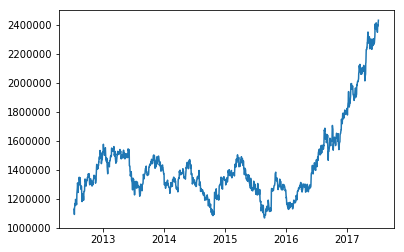

In [125]:
#raw data plotting
timeseries, dates = load_snp_close()
dates = [dt.datetime.strptime(d,'%Y-%m-%d').date() for d in dates]
plt.plot(dates, timeseries)

In [126]:
#preprocessing data
TRAIN_SIZE = 20
TARGET_TIME = 1
LAG_SIZE = 1
EMB_SIZE = 1

X, Y = split_into_chunks(timeseries, TRAIN_SIZE, TARGET_TIME, LAG_SIZE, binary=False, scale=True)
X, Y = np.array(X), np.array(Y)
X_train, X_test, Y_train, Y_test = create_Xt_Yt(X, Y, percentage=0.9)

Xp, Yp = split_into_chunks(timeseries, TRAIN_SIZE, TARGET_TIME, LAG_SIZE, binary=False, scale=False)
Xp, Yp = np.array(Xp), np.array(Yp)
X_trainp, X_testp, Y_trainp, Y_testp = create_Xt_Yt(Xp, Yp, percentage=0.9)

In [127]:
model = Sequential()
model.add(Dense(500, input_shape = (TRAIN_SIZE, )))
model.add(Activation('relu'))
model.add(Dropout(0.25))
model.add(Dense(250))
model.add(Activation('relu'))
model.add(Dense(1))
model.add(Activation('linear'))
model.compile(optimizer='adam',
              loss='mse')

print("Training...")
model.fit(X_train, 
          Y_train, 
          epochs=30, 
          batch_size = 128, 
          verbose=0)

print("Evaluating...")
score = model.evaluate(X_test, Y_test, batch_size=128)
print("\nTest loss(scaled mse):" + str(score))

Training...
Evaluating...
128/129 [============================>.] - ETA: 0s
Test loss(scaled mse):0.0454827758787


In [128]:
predicted = model.predict(X_test)


#Get mean and standard deviation from test chunk
params = []
for xt in X_testp:
    xt = np.array(xt)
    mean_ = xt.mean()
    scale_ = xt.std()
    params.append([mean_, scale_])

new_predicted = []
# restoring
for pred, par in zip(predicted, params):
    a = pred*par[1]
    a += par[0]
    new_predicted.append(a)
    
#mse = mean_squared_error(predicted, new_predicted)
#print(mse)

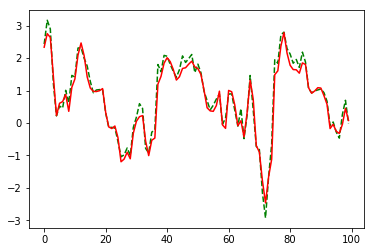

In [129]:
#Scaled Result
try:
    fig = plt.figure()
    plt.plot(Y_test[:100], "--", color='green') # SCALED DATA used in training
    plt.plot(predicted[:100], color='red') # PREDICTION from trained model
    plt.show()
except Exception as e:
    print(str(e))

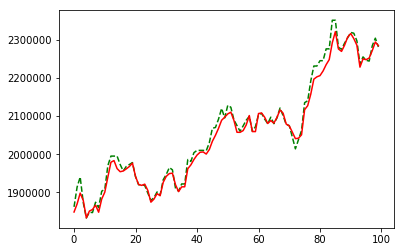

In [130]:
#restored Result
try:
    fig = plt.figure()
    plt.plot(Y_testp[:100], "--", color='green') # ACTUAL DATA
    plt.plot(new_predicted[:100], color='red') # restored PREDICTION from trained model
    plt.show()
except Exception as e:
    print(str(e))

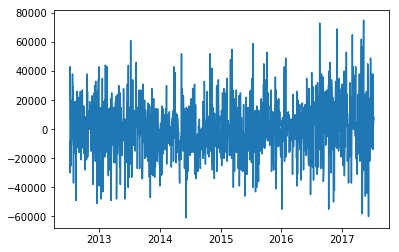

In [131]:
timeseries, dates = load_snp_returns()
dates = [dt.datetime.strptime(d,'%Y-%m-%d').date() for d in dates]
plt.plot(dates, timeseries)

In [132]:
TRAIN_SIZE = 20
TARGET_TIME = 1
LAG_SIZE = 1
EMB_SIZE = 1

X, Y = split_into_chunks(timeseries, TRAIN_SIZE, TARGET_TIME, LAG_SIZE, binary=True, scale=True)
X, Y = np.array(X), np.array(Y)
X_train, X_test, Y_train, Y_test = create_Xt_Yt(X, Y, percentage=0.9)

In [133]:
model = Sequential()
model.add(Dense(500, input_shape = (TRAIN_SIZE, )))
model.add(Activation('relu'))
model.add(Dropout(0.25))
model.add(Dense(250))
model.add(Activation('relu'))
model.add(Dense(2))
model.add(Activation('softmax'))
model.compile(optimizer='adam', 
                loss='binary_crossentropy', 
                metrics=['accuracy'])

print("Training...")
model.fit(X_train, 
          Y_train, 
          epochs=30, 
          batch_size = 128, 
          verbose=0)

print("Evaluating...")
score = model.evaluate(X_test, Y_test, batch_size=128)
print("\nTest loss and accuracy:" + str(score))

Training...
Evaluating...
128/129 [============================>.] - ETA: 0s
Test loss and accuracy:[0.86057175176088196, 0.47286821705426357]
